In [ ]:
import os, time
import imageio
import itertools
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, Flatten, Concatenate
from tensorflow.keras.initializers import RandomNormal

# models

In [ ]:
def make_generator_model():
    noise = tf.keras.Input(shape=(100,))
    label = tf.keras.Input(shape=(10,))

    x = tf.keras.layers.Reshape((1, 1, 100))(noise)

    x = Conv2DTranspose(128*2, 4, strides=1, padding='valid', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    y = tf.keras.layers.Reshape((1, 1, 10))(label)

    y = Conv2DTranspose(128*2, 4, strides=1, padding='valid', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.LeakyReLU()(y)

    x = tf.concat([x, y], axis=3)

    x = Conv2DTranspose(128*2, 4, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = Conv2DTranspose(1, 4, strides=2, padding='same', use_bias=False, activation='tanh', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)

    return tf.keras.Model(inputs=[noise, label], outputs=x)

In [ ]:
def make_discriminator_model():
    image = tf.keras.Input(shape=(32, 32, 1))
    label = tf.keras.Input(shape=(32, 32, 10))

    x = Conv2D(128/2, 4, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(image)
    x = tf.keras.layers.LeakyReLU()(x)

    y = Conv2D(128/2, 4, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(label)
    y = tf.keras.layers.LeakyReLU()(y)

    x = tf.concat([x, y], axis=3)

    x = Conv2D(128*2, 4, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = Conv2D(128*4, 4, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = Conv2D(1, 4, strides=1, padding='valid', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)

    return tf.keras.Model(inputs=[image, label], outputs=x)

In [ ]:
def show_result(noise, label_one_hot):
    test_images = generator([noise, label_one_hot], training=False)

    fig, axes = plt.subplots(1, 10, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(test_images[i, :, :, 0], cmap='gray')
        ax.axis('off')
    plt.show()

In [ ]:
def show_train_hist(hist):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']
    plt.figure(figsize=(5, 2))  # Размер 8x6 дюймов

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc='best')  # Автоматически выбирает лучшее место для легенды
    plt.grid(True)
    plt.tight_layout()

    plt.show()


# oooo

In [ ]:
# training parameters
BATCH_SIZE = 128
LEARNING_RATE = 0.00002
TRAIN_EPOCH = 20
BUFFER_SIZE = 60000
IMG_SIZE = 32
NOISE_DIM = 100

SEED = tf.random.normal((10, NOISE_DIM))
SEED_LABEL = tensor = tf.range(10)
SEED_LABEL_one_hot = tf.one_hot(SEED_LABEL, depth=10)


(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()

def preprocess_image(image):
    image = tf.expand_dims(image, axis = 2)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5
    return image

def preprocess_label(label):
    return tf.cast(label, tf.int64)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(lambda x, y: (preprocess_image(x), preprocess_label(y)))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()
# generator.summary()
# display(tf.keras.utils.plot_model(discriminator, show_shapes=True))

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE) #SGD

fill = np.zeros((10, 10, 32, 32))
for i in range(10):
    fill[i, i, :, :] = 1
fill = tf.convert_to_tensor(fill, dtype=tf.int32)

[1/20] - ptime: 66.73, g loss: 3.32, d loss: 0.11


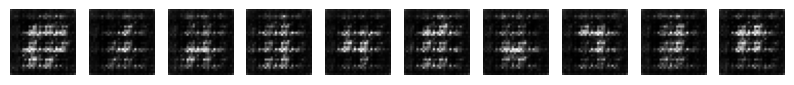

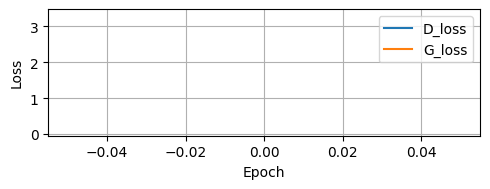

[2/20] - ptime: 61.36, g loss: 3.43, d loss: 0.12


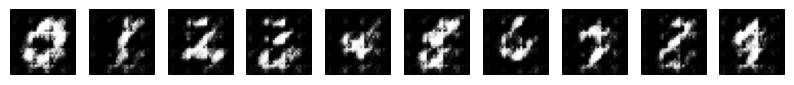

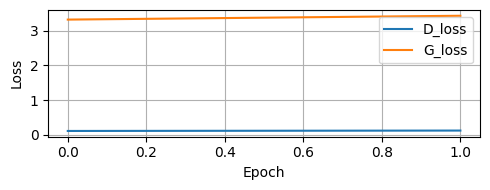

[3/20] - ptime: 81.90, g loss: 3.26, d loss: 0.19


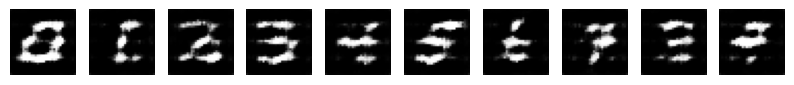

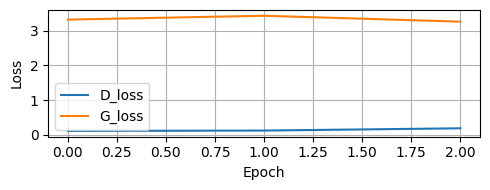

[4/20] - ptime: 61.44, g loss: 3.20, d loss: 0.21


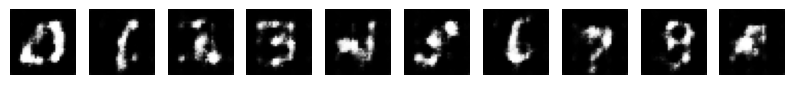

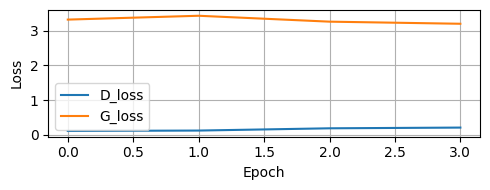

[5/20] - ptime: 81.90, g loss: 3.29, d loss: 0.19


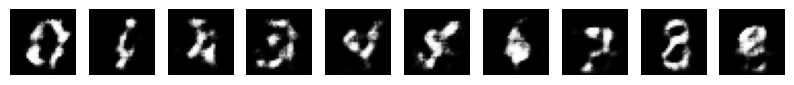

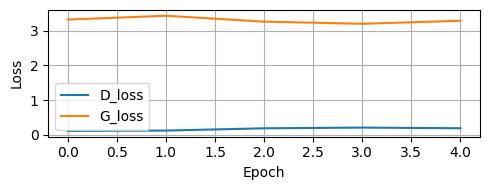

[6/20] - ptime: 61.73, g loss: 3.33, d loss: 0.19


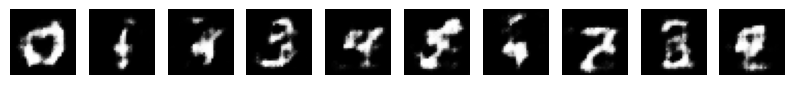

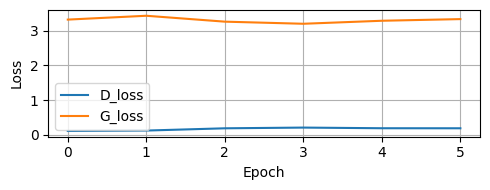

[7/20] - ptime: 61.15, g loss: 3.36, d loss: 0.18


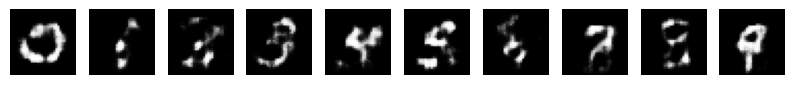

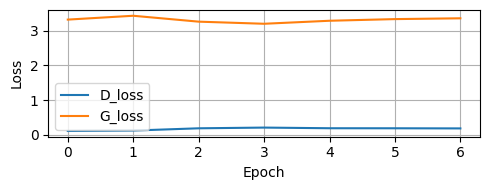

[8/20] - ptime: 61.17, g loss: 3.35, d loss: 0.19


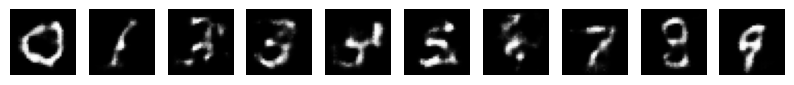

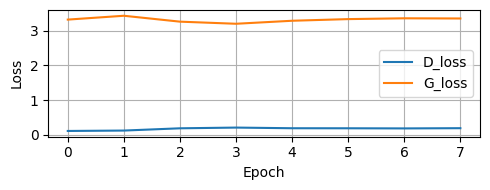

[9/20] - ptime: 61.07, g loss: 3.22, d loss: 0.21


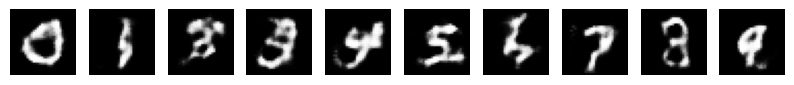

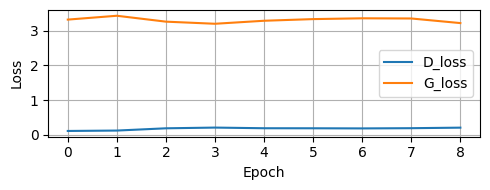

[10/20] - ptime: 81.90, g loss: 3.12, d loss: 0.21


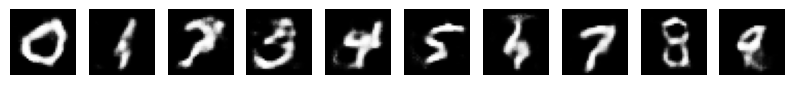

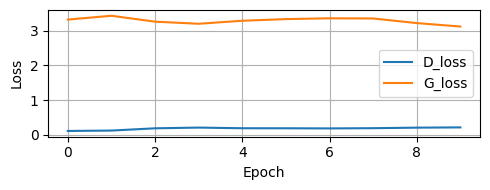

learning rate change!
[11/20] - ptime: 81.90, g loss: 2.98, d loss: 0.18


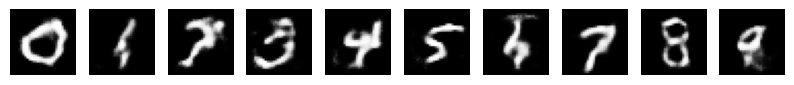

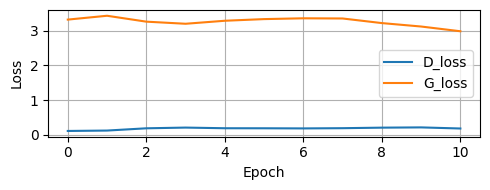

[12/20] - ptime: 81.90, g loss: 2.97, d loss: 0.18


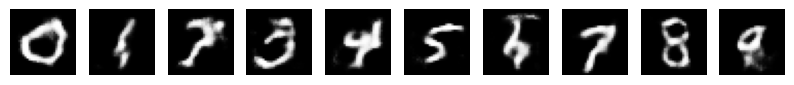

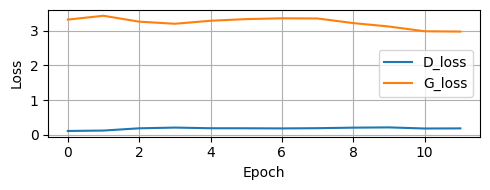

[13/20] - ptime: 61.59, g loss: 3.03, d loss: 0.17


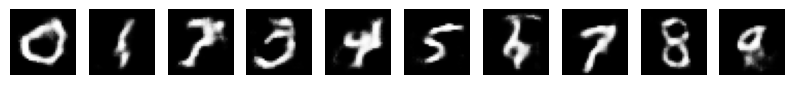

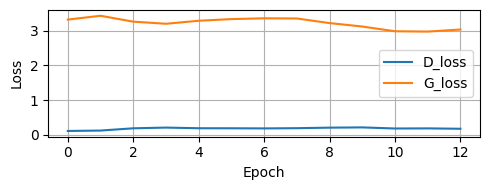

[14/20] - ptime: 60.96, g loss: 3.04, d loss: 0.17


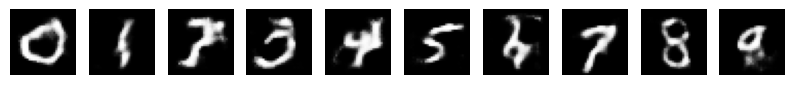

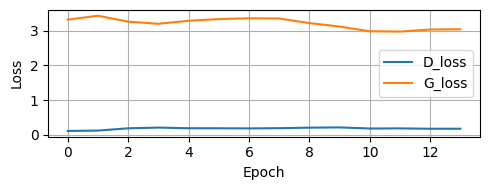

[15/20] - ptime: 60.73, g loss: 3.07, d loss: 0.17


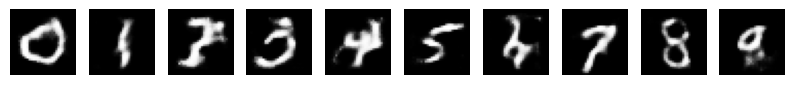

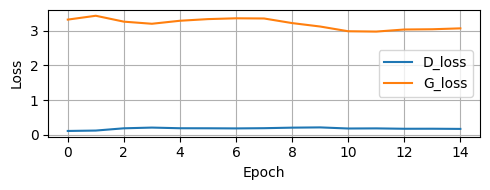

learning rate change!
[16/20] - ptime: 60.82, g loss: 3.08, d loss: 0.16


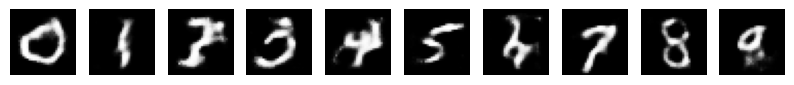

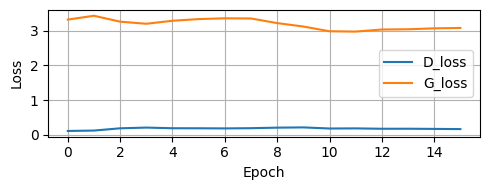

[17/20] - ptime: 60.36, g loss: 3.08, d loss: 0.16


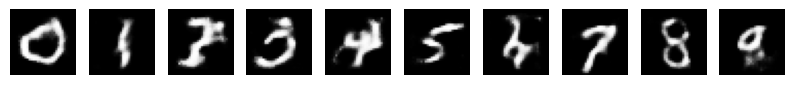

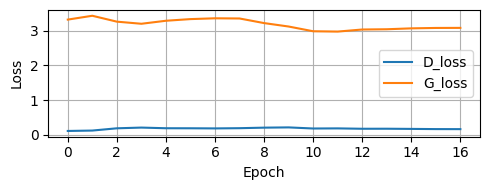

[18/20] - ptime: 60.56, g loss: 3.10, d loss: 0.16


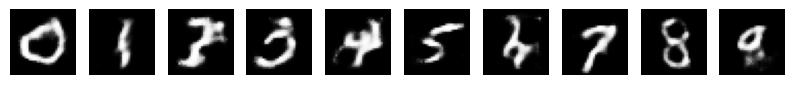

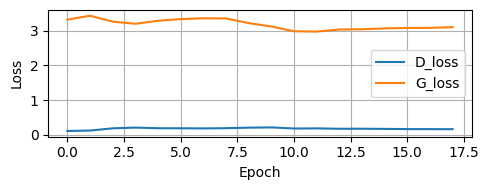

[19/20] - ptime: 60.60, g loss: 3.12, d loss: 0.16


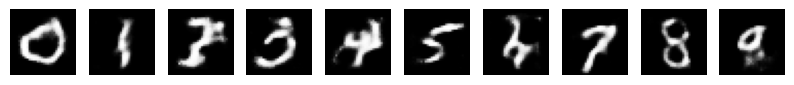

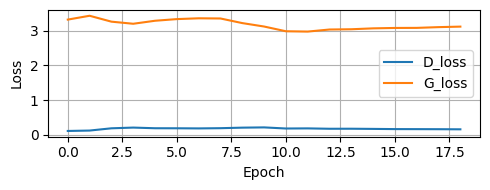

[20/20] - ptime: 60.39, g loss: 3.10, d loss: 0.16


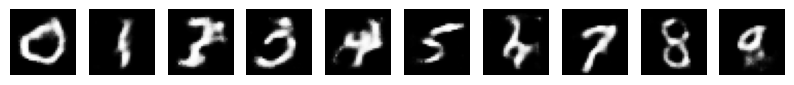

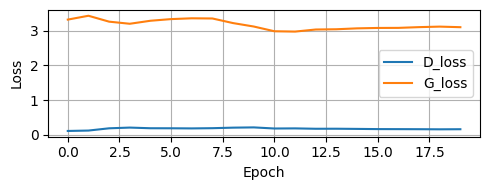

In [ ]:
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

start_time = time.time()
for epoch in range(TRAIN_EPOCH):
  D_losses = []
  G_losses = []

  # learning rate decay
  if (epoch+1) == 11 or (epoch+1) == 16:
      generator_optimizer.learning_rate.assign(generator_optimizer.learning_rate / 10.0)
      discriminator_optimizer.learning_rate.assign(discriminator_optimizer.learning_rate / 10.0)
      print("learning rate change!")

  epoch_start_time = time.time()

  g_l=d_l=i = 0
  for real_images, real_labels in train_dataset:
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        noise = tf.random.normal((BATCH_SIZE, NOISE_DIM))
        fake_labels = tf.random.uniform((BATCH_SIZE,), minval=0, maxval=10, dtype=tf.int32)

        fake_labels_one_hot = tf.one_hot(fake_labels, depth=10)
        fake_labels_matrix = tf.gather(fill, fake_labels, axis=0)
        fake_labels_matrix = tf.transpose(fake_labels_matrix, perm=[0, 2, 3, 1])
        real_labels_matrix = tf.gather(fill, real_labels, axis=0)
        real_labels_matrix = tf.transpose(real_labels_matrix, perm=[0, 2, 3, 1])

        results_on_real_data = discriminator([real_images, real_labels_matrix], training=True)
        disc_real_loss = cross_entropy(tf.ones_like(results_on_real_data), results_on_real_data)

        generated_images = generator([noise, fake_labels_one_hot], training=True)
        results_on_fake_data = discriminator([generated_images, fake_labels_matrix], training=True)
        disc_fake_loss = cross_entropy(tf.zeros_like(results_on_fake_data), results_on_fake_data)
        disc_loss = disc_real_loss + disc_fake_loss
        gen_loss = cross_entropy(tf.ones_like(results_on_fake_data), results_on_fake_data)

      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

      i += 1
      d_l += disc_loss.numpy()
      D_losses.append(disc_loss.numpy())
      g_l += gen_loss.numpy()
      G_losses.append(gen_loss.numpy())

  epoch_end_time = time.time()
  per_epoch_ptime = epoch_end_time - epoch_start_time
  print('[%d/%d] - ptime: %.2f, g loss: %.2f, d loss: %.2f' % ((epoch + 1), TRAIN_EPOCH, per_epoch_ptime, g_l/i, d_l/i))
  show_result(SEED, SEED_LABEL_one_hot)
  train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
  train_hist['D_losses'].append(d_l/i)
  train_hist['G_losses'].append(g_l/i)
  train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
  show_train_hist(train_hist)

end_time = time.time()

In [ ]:
# train_hist = {}
# train_hist['D_losses'] = []
# train_hist['G_losses'] = []
# train_hist['per_epoch_ptimes'] = []
# train_hist['total_ptime'] = []

# start_time = time.time()
# for epoch in range(TRAIN_EPOCH):
#   D_losses = []
#   G_losses = []

#   # learning rate decay
#   if (epoch+1) == 11:
#       generator_optimizer.learning_rate.assign(generator_optimizer.learning_rate / 10.0)
#       discriminator_optimizer.learning_rate.assign(discriminator_optimizer.learning_rate / 10.0)
#       print("learning rate change!")

#   if (epoch+1) == 16:
#       generator_optimizer.learning_rate.assign(generator_optimizer.learning_rate / 10.0)
#       discriminator_optimizer.learning_rate.assign(discriminator_optimizer.learning_rate / 10.0)
#       print("learning rate change!")

#   epoch_start_time = time.time()

#   g_l=d_l=i = 0
#   for real_images, real_labels in train_dataset:
#       with tf.GradientTape() as disc_tape:
#         noise = tf.random.normal((BATCH_SIZE, NOISE_DIM))
#         fake_labels = tf.random.uniform((BATCH_SIZE,), minval=0, maxval=10, dtype=tf.int32)

#         fake_labels_one_hot = tf.one_hot(fake_labels, depth=10)
#         fake_labels_matrix = tf.gather(fill, fake_labels, axis=0)
#         fake_labels_matrix = tf.transpose(fake_labels_matrix, perm=[0, 2, 3, 1])
#         real_labels_matrix = tf.gather(fill, real_labels, axis=0)
#         real_labels_matrix = tf.transpose(real_labels_matrix, perm=[0, 2, 3, 1])

#         results_on_real_data = discriminator([real_images, real_labels_matrix], training=True)
#         disc_real_loss = cross_entropy(tf.ones_like(results_on_real_data), results_on_real_data)

#         generated_images = generator([noise, fake_labels_one_hot], training=True)
#         results_on_fake_data = discriminator([generated_images, fake_labels_matrix], training=True)
#         disc_fake_loss = cross_entropy(tf.zeros_like(results_on_fake_data), results_on_fake_data)
#         disc_loss = disc_real_loss + disc_fake_loss

#       gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
#       discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#       i += 1
#       d_l += disc_loss.numpy()
#       D_losses.append(disc_loss.numpy())
#       # ------------------------------------------------------------------------

#       with tf.GradientTape() as gen_tape:
#         noise = tf.random.normal((BATCH_SIZE, NOISE_DIM))
#         fake_labels = tf.random.uniform((BATCH_SIZE,), minval=0, maxval=10, dtype=tf.int32)

#         fake_labels_one_hot = tf.one_hot(fake_labels, depth=10)
#         fake_labels_matrix = tf.gather(fill, fake_labels, axis=0)
#         fake_labels_matrix = tf.transpose(fake_labels_matrix, perm=[0, 2, 3, 1])

#         generated_images = generator([noise, fake_labels_one_hot], training=True)
#         results_on_fake_data = discriminator([generated_images, fake_labels_matrix], training=True)
#         gen_loss = cross_entropy(tf.ones_like(results_on_fake_data), results_on_fake_data)

#       gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#       generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

#       g_l += gen_loss.numpy()
#       G_losses.append(gen_loss.numpy())

#   epoch_end_time = time.time()
#   per_epoch_ptime = epoch_end_time - epoch_start_time
#   print('[%d/%d] - ptime: %.2f, g loss: %.2f, d loss: %.2f' % ((epoch + 1), TRAIN_EPOCH, per_epoch_ptime, g_l/i, d_l/i))
#   show_result(SEED, SEED_LABEL_one_hot)
#   train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
#   train_hist['D_losses'].append(d_l/i)
#   train_hist['G_losses'].append(g_l/i)
#   train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
#   show_train_hist(train_hist)

# end_time = time.time()

In [ ]:
# @tf.function
# def train_step(real_images, real_labels, D_losses, G_losses):
#   with tf.GradientTape() as disc_tape:
#     noise = tf.random.normal((BATCH_SIZE, NOISE_DIM))
#     fake_labels = tf.random.uniform((BATCH_SIZE,), minval=0, maxval=10, dtype=tf.int32)

#     fake_labels_one_hot = tf.one_hot(fake_labels, depth=10)
#     fake_labels_matrix = tf.gather(fill, fake_labels, axis=0)
#     fake_labels_matrix = tf.transpose(fake_labels_matrix, perm=[0, 2, 3, 1])
#     real_labels_matrix = tf.gather(fill, real_labels, axis=0)
#     real_labels_matrix = tf.transpose(real_labels_matrix, perm=[0, 2, 3, 1])

#     results_on_real_data = discriminator([real_images, real_labels_matrix], training=True)
#     disc_real_loss = cross_entropy(tf.ones_like(results_on_real_data), results_on_real_data)

#     generated_images = generator([noise, fake_labels_one_hot], training=True)
#     results_on_fake_data = discriminator([generated_images, fake_labels_matrix], training=True)
#     disc_fake_loss = cross_entropy(tf.zeros_like(results_on_fake_data), results_on_fake_data)
#     disc_loss = disc_real_loss + disc_fake_loss

#   gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
#   discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#   global d_l, g_l, i
#   i += 1
#   d_l += disc_loss.numpy()
#   D_losses.append(disc_loss.numpy())
#   # ------------------------------------------------------------------------

#   with tf.GradientTape() as gen_tape:
#     noise = tf.random.normal((BATCH_SIZE, NOISE_DIM))
#     fake_labels = tf.random.uniform((BATCH_SIZE,), minval=0, maxval=10, dtype=tf.int32)

#     fake_labels_one_hot = tf.one_hot(fake_labels, depth=10)
#     fake_labels_matrix = tf.gather(fill, fake_labels, axis=0)
#     fake_labels_matrix = tf.transpose(fake_labels_matrix, perm=[0, 2, 3, 1])

#     generated_images = generator([noise, fake_labels_one_hot], training=True)
#     results_on_fake_data = discriminator([generated_images, fake_labels_matrix], training=True)
#     gen_loss = cross_entropy(tf.ones_like(results_on_fake_data), results_on_fake_data)

#   gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#   generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

#   g_l += gen_loss.numpy()
#   G_losses.append(gen_loss.numpy())

In [ ]:
# g_l=d_l=i = 0
# start_time = end_time = 0
# def train():
#   global d_l, g_l, i, start_time, end_time
#   start_time = time.time()
#   for epoch in range(TRAIN_EPOCH):
#     D_losses = []
#     G_losses = []

#     # learning rate decay
#     if (epoch+1) == 11 or (epoch+1) == 16:
#         generator_optimizer.learning_rate.assign(generator_optimizer.learning_rate / 10.0)
#         discriminator_optimizer.learning_rate.assign(discriminator_optimizer.learning_rate / 10.0)
#         print("learning rate change!")

#     epoch_start_time = time.time()
#     g_l=d_l=i = 0
#     for real_images, real_labels in train_dataset:
#         train_step(real_images, real_labels, D_losses, G_losses) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#     epoch_end_time = time.time()

#     per_epoch_ptime = epoch_end_time - epoch_start_time
#     print('[%d/%d] - ptime: %.2f, g loss: %.2f, d loss: %.2f' % ((epoch + 1), TRAIN_EPOCH, per_epoch_ptime, g_l/i, d_l/i))
#     show_result(SEED, SEED_LABEL_one_hot)
#     train_hist['D_losses'].append(d_l/i)
#     train_hist['G_losses'].append(g_l/i)
#     train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
#     show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

#   end_time = time.time()

In [ ]:
# total_ptime = end_time - start_time
# train_hist['total_ptime'].append(total_ptime)

# show_train_hist(train_hist)

# images = []
# for e in range(TRAIN_EPOCH):
    # img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    # images.append(imageio.imread(img_name))
# imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

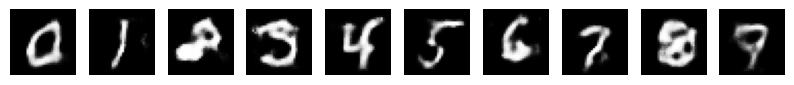

In [ ]:
s = tf.random.normal((10, NOISE_DIM))
l = tensor = tf.range(10)
l = tf.one_hot(l, depth=10)

show_result(s,l)